In [12]:
import networkx as nx
import gurobipy as gb
import os
import matplotlib.pyplot as plt

In [13]:
# Drawing functions

def DrawInitG(G, withedges=False):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red')
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    if withedges:
        nx.draw_networkx_edges(G,pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'cost').get('cost') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    
    plt.axis('off')
    plt.show()
    
def DrawSol(G, x):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red',
                           label=[G.nodes()])
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    for u,v in G.edges():
        if x[u,v].x > 0.01 and x[u,v].x < 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='r')
            
            nx.draw_networkx_edge_labels(G, pos=pos,
                                         edge_labels={(u,v):'{:.2f}'.format(x[u,v].x)})
        
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='k')
        

    
    #edges_in_sol = [(u,v)  for u,v in G.edges() if x[u,v].x > 0.1]

    
    plt.axis('off')
    plt.show()
    
class args:
    filename = None
    figsize = 30,60
    scale = 40
    

## Prize Collecting Steiner Tree (PCST)

### Problem definition

>**Given**
> * A symmetric graph $G=(V,E)$ and a cost $c_e > 0$ for each edge in $E$;
> * A root node $\{0\}$;
> * A revenue $p_j > 0$ for each node $j \in V \setminus \{0\}$;

>
>**Find**
>A subtree $T$ rooted in $\{0\}$ that **maximizes** the sum of the revenues of 
>the nodes in $T$ **minus** the sum of the costs of the edges in $T$

### Formulation with *positional* variables (MTZ formulation)

#### Variables
$$
x_{ij} = \begin{cases}1 \text{ if arc $(i, j)$ is in the arborescence} \\
0 \text{ otherwise}
\end{cases}
$$

$$
y_j = \begin{cases} 1 \text{ if node j is in the arborescence}\\
0 \text{ otherwise}
\end{cases}
$$

$$ 
u_j = \{\text{number of arcs in the dipath (if any) induced by $x$ from \{0\} to $j$}\}
$$

#### MTZ formulation

$$
\begin{align}
\min & \sum_{(i,j) \in A} c_{ij} x_{ij} - \sum_{j \in V \setminus \{0\}} p_j y_j \\
\text{subject}& \text{ to} \\
y_0 & = 1 \\
\sum_{i \in \delta^-(j)} x_{ij} & = y_j \;\; \forall j \in V\\
(n+1)x_{ij} + u_i - u_j &\le n \;\; \forall (i,j) \in A \\
x_{jk} &\le y_j \;\; \forall k \in \delta^+(j), \;\; \forall j \in V \setminus\{0\}\\
0 \le u_j & \le n \;\; \forall j \in V \\ 
x_{ij} & \in \{0,1\} \;\; \forall(i,j) \in A \\
y_j & \in \{0,1\} \;\; \forall j \in V
\end{align}
$$


In [14]:
# Read the graph in the graphML format

args.filename = 'graph19062017.gml'

basename = os.path.splitext(args.filename)[0]

G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

G has 30 nodes and 435 edges


In [15]:
root = 1 # fix the root
D = G.to_directed() # Define a bidirected copy of G

pcst = gb.Model()
pcst.ModelSense = gb.GRB.MAXIMIZE

In [16]:
## Variables definition

x = pcst.addVars(D.edges(), vtype=gb.GRB.BINARY, \
                 obj = [- D[i][j]['cost'] for i,j in D.edges()], \
                 name = 'x')

y = pcst.addVars (G.nodes(), vtype = gb.GRB.BINARY, \
                  obj = [G.nodes[i]['profit'] for i in G.nodes()],\
                 name = 'y')

u = pcst.addVars (G.nodes(), vtype = gb.GRB.CONTINUOUS, 
                  lb = 0.0, ub = G.number_of_nodes(),\
                 name = 'u')

pcst.write('pcst.lp')

In [17]:
## Constraints definition

# Root is in the solution
pcst.addConstr(y[root] == 1, name = 'Fix')

pcst.update()

# Each node has exactly one incoming arc

pcst.addConstrs((x.sum('*',j) == y[j] for j in G.nodes() if j != root), name='Node')

# Precedence constraints (MTZ constraints)

pcst.addConstrs(((G.number_of_nodes() +  1) * x[i,j] + u[i] - u[j] <= G.number_of_nodes() for i,j in D.edges()), name = 'MTZ')

# Connectivity constraints

pcst.addConstrs((x[j,k] <= y[j] for j in G.nodes() \
                 if j != root for k in D.neighbors(j)), name = 'Connect')
pcst.update() 

pcst.write('pcst.lp')

### We will need a constraint on the budget for Ex1.1 and Ex1.2
 - Budget constraint: $ \sum_{(i,j) \in A} c_{ij} \cdot x_{ij} \le b $

## **Ex1.1** The company implements the network in the first year by paying 500 Euro of interest on the budget anticipation

In [18]:
budget = 12000 # (1) Budget for 1st year
costs ={(i,j): D[i][j]['cost'] for (i,j) in D.edges()}

pcst.addConstr(x.prod(costs) <= budget, 'Budget')
pcst.update() 
pcst.write('pcst_budget.lp')

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1742 rows, 930 columns and 6033 nonzeros
Model fingerprint: 0x151685b2
Variable types: 30 continuous, 900 integer (900 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+03]
  Objective range  [1e+02, 7e+03]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 1e+04]
Found heuristic solution: objective 310.0000000
Presolve removed 62 rows and 31 columns
Presolve time: 0.02s
Presolved: 1680 rows, 899 columns, 5854 nonzeros
Variable types: 29 continuous, 870 integer (870 binary)

Root relaxation: objective 1.283813e+04, 65 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 12838.1290    0   28  310.00000 12838.1290  4041%     -    0s
H    0     0                    1439.0000000 

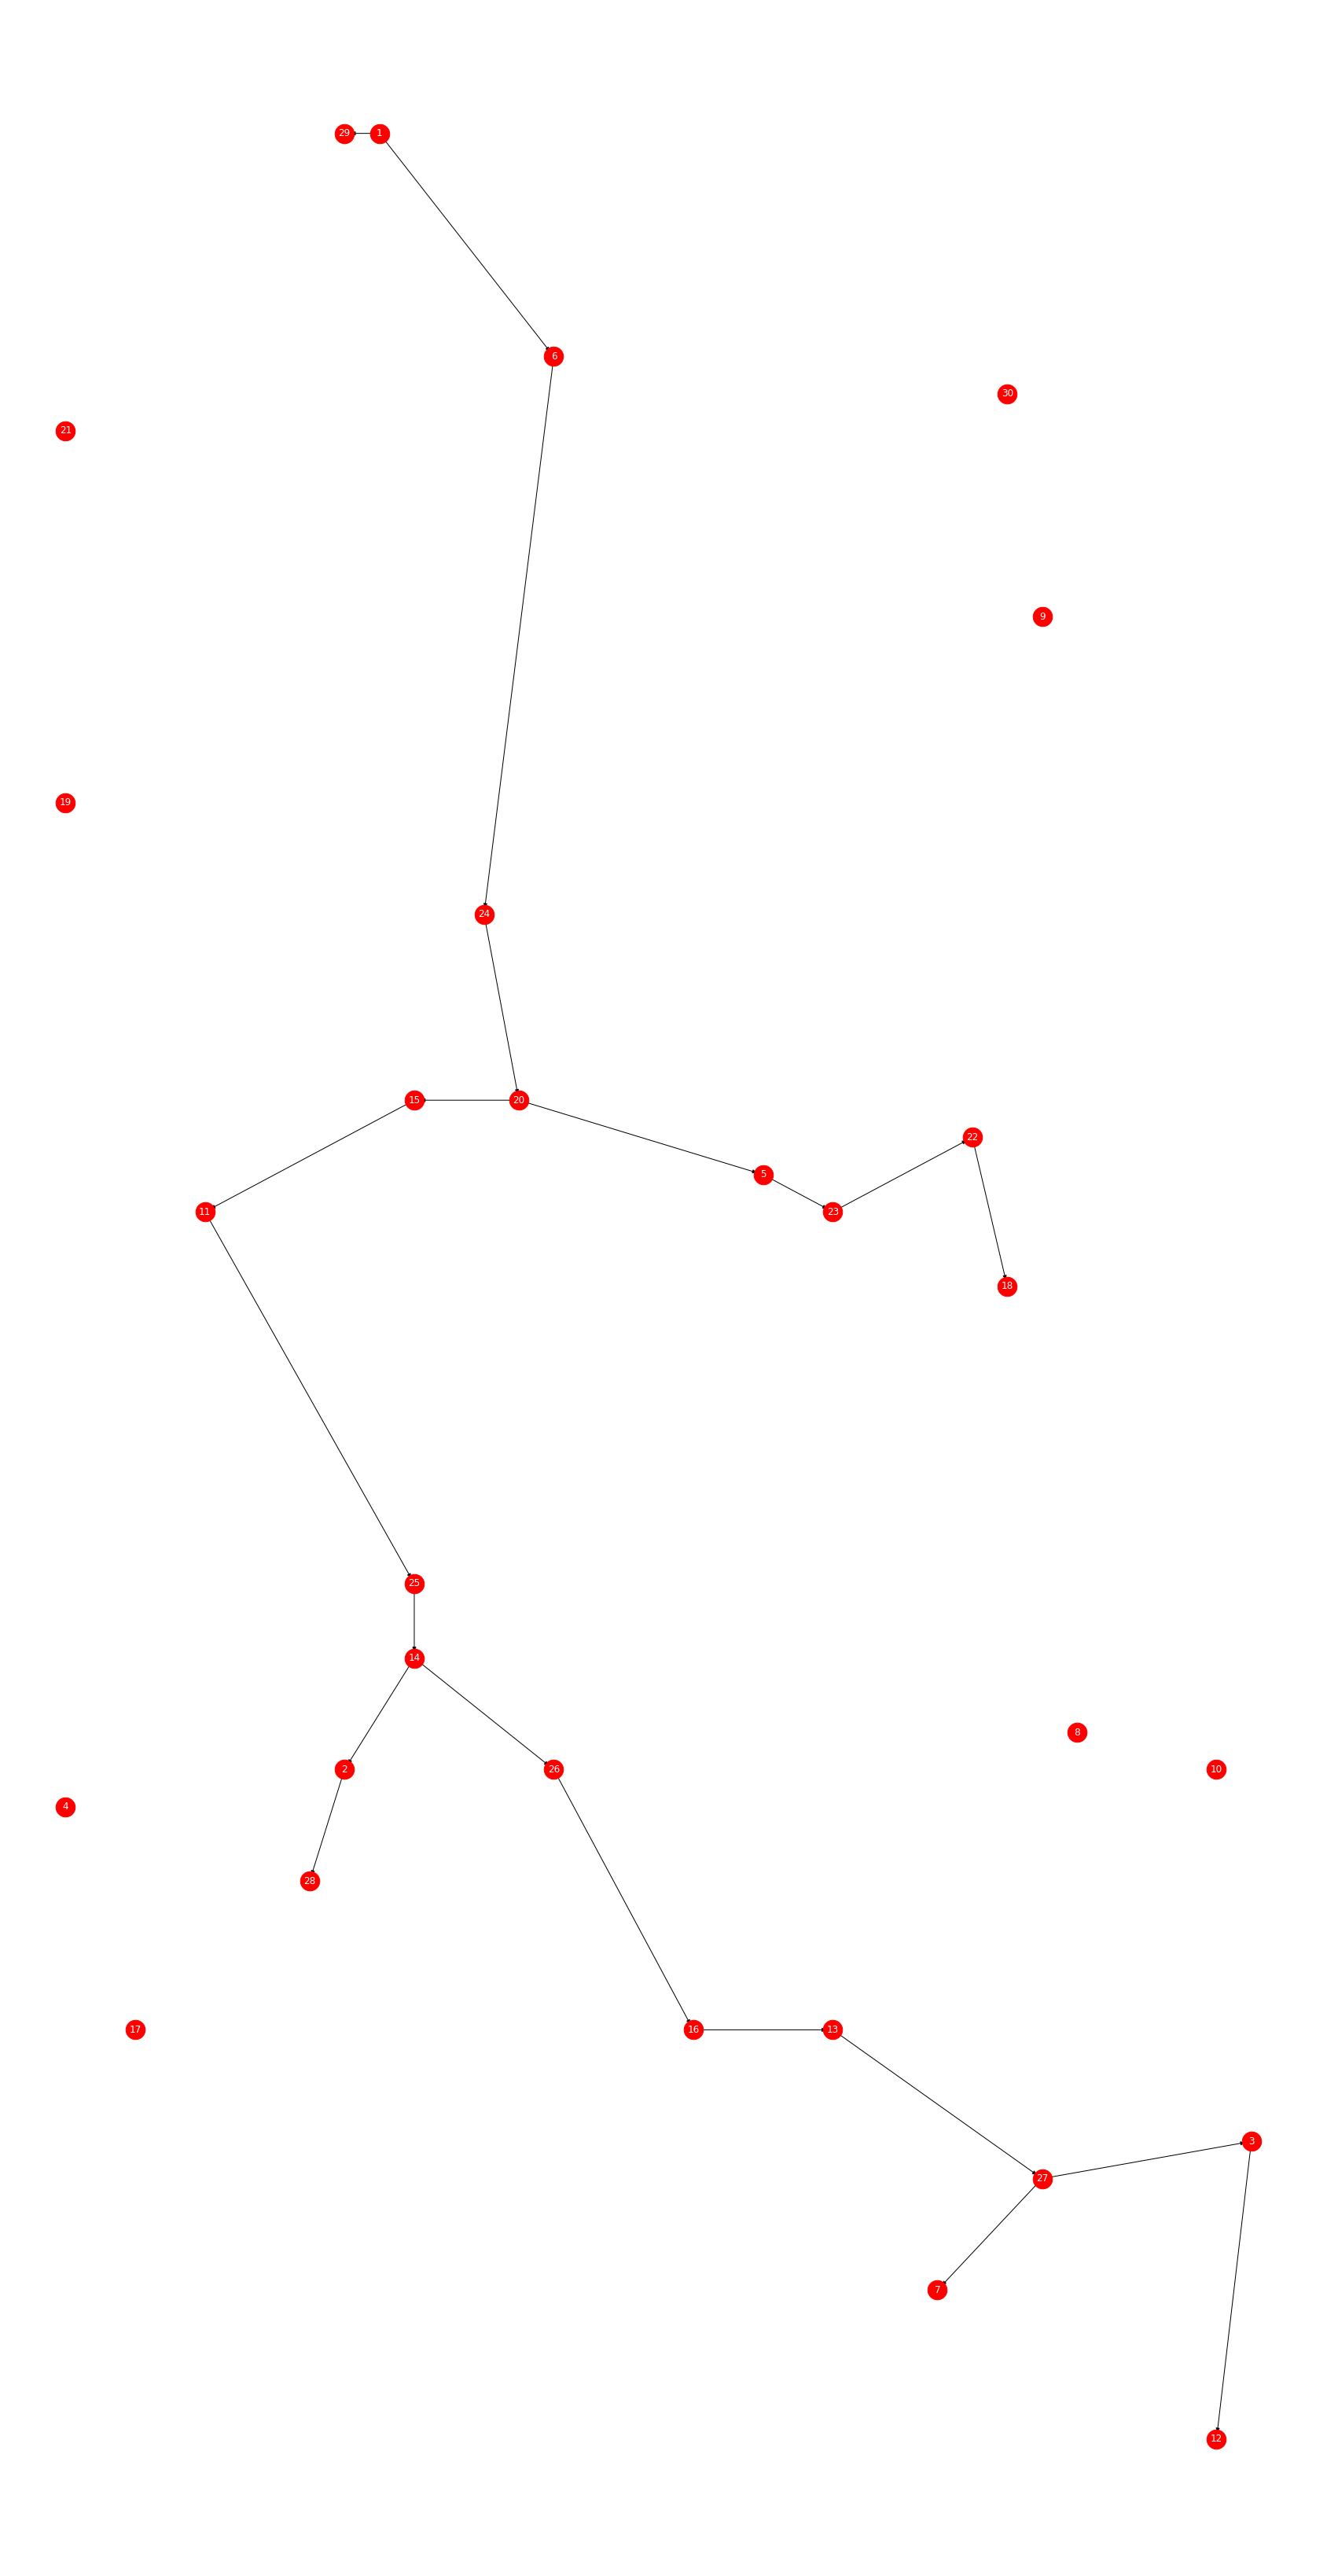

In [19]:
pcst.optimize()

totalcost = 500

for i,j in D.edges():
        if x[i,j].x > 0.1:
            totalcost += D[i][j]['cost']
            
print("\n----------------------------------------------------------\n")
print ("Total cost", totalcost)
print("\n----------------------------------------------------------\n")

DrawSol(D,x)

## **Ex1.2** The company deploys  the  network  in  three  years  respecting  the  budget constraint for each year

In [21]:
# we need to delete the constraint added for Ex1.1
# remove the constraint from Ex1.1
pcst.remove(pcst.getConstrByName('Budget'))
pcst.update() 
pcst.write('pcst_budget.lp')

In [22]:
budget = 12000 + 2000 + 600 # (2) sum of all budget 

pcst.addConstr(x.prod(costs) <= budget, 'Budget')

pcst.update() 
pcst.write('pcst_budget.lp')

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1742 rows, 930 columns and 6033 nonzeros
Model fingerprint: 0x85221189
Variable types: 30 continuous, 900 integer (900 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+03]
  Objective range  [1e+02, 7e+03]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 1e+04]

MIP start from previous solve produced solution with objective 8188 (0.02s)
Loaded MIP start from previous solve with objective 8188

Presolve removed 59 rows and 31 columns
Presolve time: 0.01s
Presolved: 1683 rows, 899 columns, 5829 nonzeros
Variable types: 29 continuous, 870 integer (870 binary)

Root relaxation: objective 1.283813e+04, 65 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 12838.1290    0   28

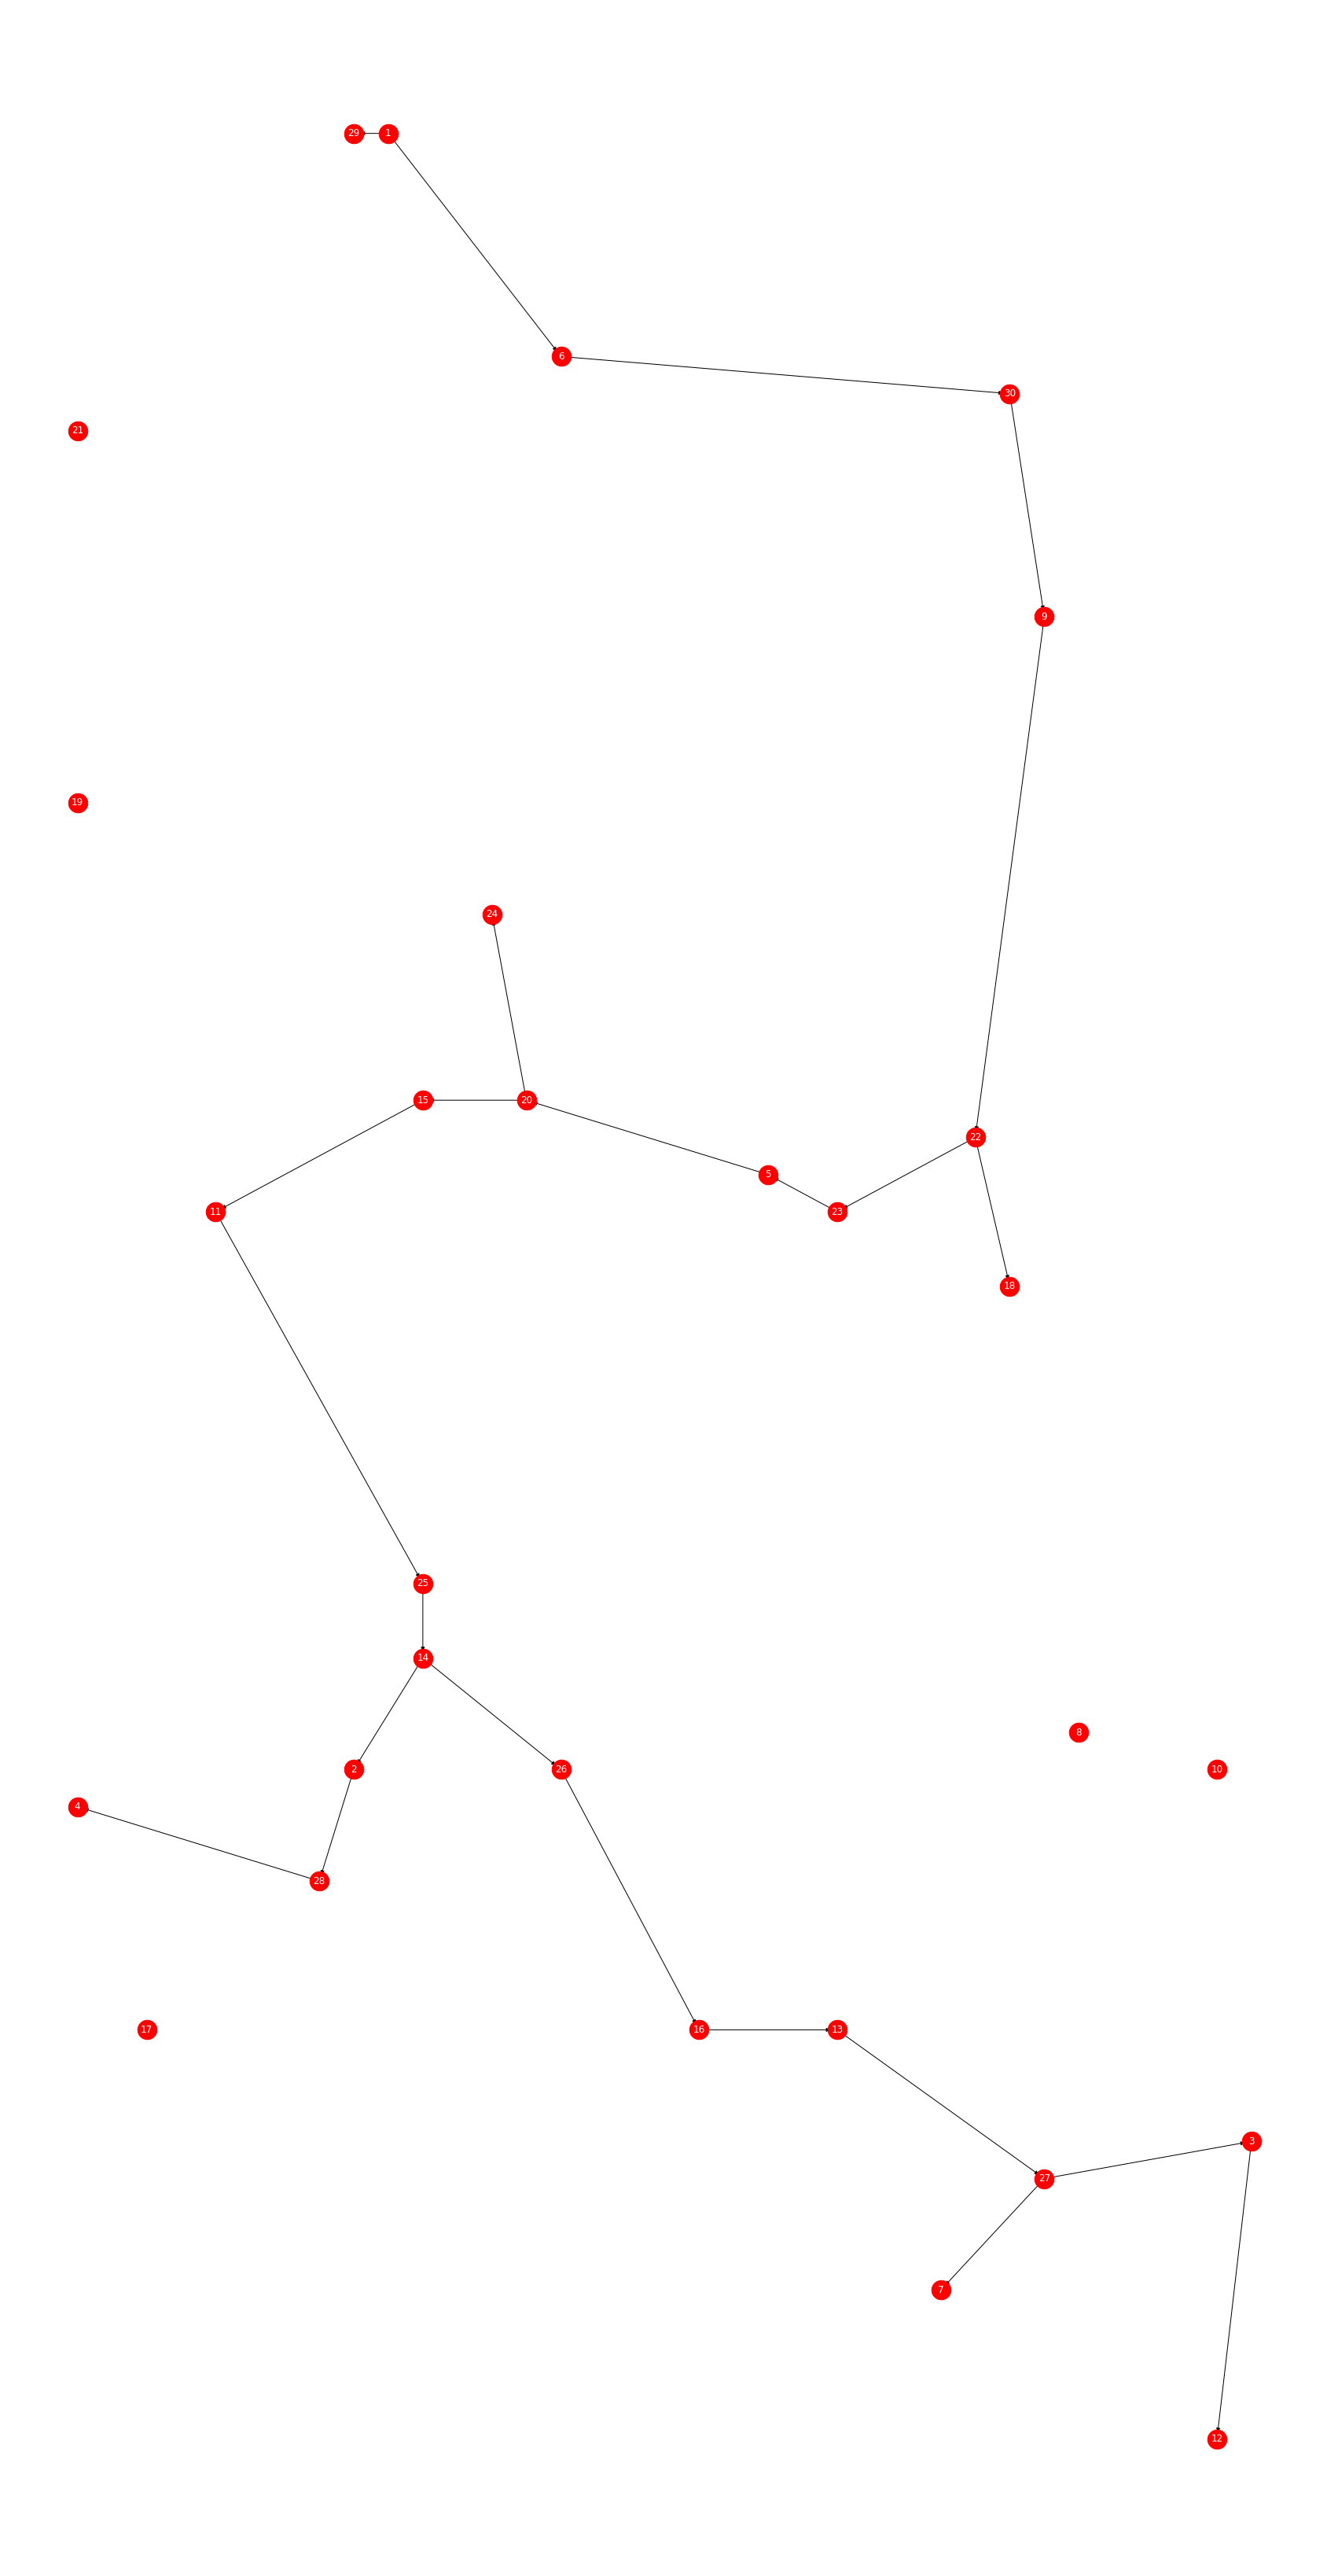

In [23]:
pcst.optimize()

totalcost = 0

for i,j in D.edges():
        if x[i,j].x > 0.1:
            totalcost += D[i][j]['cost']
            
print("\n----------------------------------------------------------\n")
print ("Total cost", totalcost)
print("\n----------------------------------------------------------\n")

DrawSol(D,x)